

# **Подготовка окружения**
Скачиваем deepxde, устанавливаем переменную окружения "DDE_BACKEND" для выбора backend=**pytorch**

In [1]:
from IPython.display import clear_output

In [2]:
# %pip install deepxde
# %pip install hyperopt
# %pip install optuna
clear_output()

In [3]:
%env DDE_BACKEND=pytorch
import time
import tqdm
# import deepxde as dde
import numpy as np
import scipy
import pandas as pd
import os
import json
import copy
import zipfile
import torch
from torch.nn import Sequential, Tanh, Linear, InstanceNorm1d, LayerNorm
from scipy.integrate import quad
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation, ArtistAnimation
from functools import partial
from copy import deepcopy
from hyperopt import hp, fmin, tpe, space_eval
import hyperopt
from PIL import Image

env: DDE_BACKEND=pytorch


In [4]:
DEVICE = 'cpu'

Фиксируем случайный seed, выбираем формат данных для тензоров в deepxde за float64

In [5]:
# dde.config.set_random_seed(123)
# dde.config.set_default_float("float64")
torch.set_default_dtype(torch.float64)

In [6]:
class ExponentialIntegral(torch.autograd.Function):
    """
    Implementation of exponential integral function Ei(x) = Integrate_{-∞}^x e^t/t dt
    """

    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return scipy.special.expi(input.detach().cpu())

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        input.to(DEVICE)
        return grad_output.to(DEVICE) * torch.exp(input) / input
    
class ReLU2(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        
        return torch.relu(input) ** 2

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        input.to(DEVICE)
        return grad_output.to(DEVICE) * 2 * torch.relu(input)
    
class OxideModel(torch.nn.Module):
    
    def __init__(
        self,
        e_state,
        v_state,
        t_state,
        b_state,
        model: str = 'second',
    ):
        super().__init__()
        self.saved = False
        self.saved_old = False
        self.model = model  
        self.e_state = e_state
        self.t_state = t_state
        self.v_state = v_state
        self.b_state = b_state
        
        parameter_config = dict(dtype=torch.float64, device=DEVICE, requires_grad=True)
        self.E = torch.nn.parameter.Parameter(torch.tensor([np.log(e_state['init'] / e_state['scale'])], **parameter_config))
        self.T_max_delta = torch.nn.parameter.Parameter(torch.tensor([0], **parameter_config))
        self.T_beg_delta = torch.nn.parameter.Parameter(torch.tensor([0], **parameter_config))
        self.V_max = torch.nn.parameter.Parameter(torch.tensor([np.log(v_state['init'] / v_state['scale'])], **parameter_config))
        
    def get_t_beg(self):
        return self.b_state['init'] + self.b_state['delta'] * (2 * torch.nn.functional.sigmoid(self.T_beg_delta * self.b_state['delta_scale']) - 1) \
                                    + self.t_state['delta'] * (2 * torch.nn.functional.sigmoid(self.T_max_delta * self.t_state['delta_scale']) - 1)
    
    def get_t_max(self):
        return self.t_state['init'] + self.t_state['delta'] * (2 * torch.nn.functional.sigmoid(self.T_max_delta * self.t_state['delta_scale']) - 1)

    def get_v_max(self):
        return torch.exp(self.V_max) * self.v_state['scale']
    
    def get_E(self):
        return torch.exp(self.E) * self.e_state['scale']
    
    def forward(self, input, global_shift):
        Ei = ExponentialIntegral.apply
        relu2 = ReLU2.apply
        
        def f(t, K, E):
            return K - E / t
        
        def integral(t, K, E):
            return torch.exp(K) * (t * torch.exp(-E / t) + E * Ei(-E / t).to(DEVICE))
        
        assert not torch.any(torch.isnan(self.E)), "NaN in s.E"
        assert not torch.any(torch.isnan(self.V_max)), f"NaN in s.V"
        assert not torch.any(torch.isnan(self.T_max_delta)), "NaN in T_max_delta"
        
        E = torch.exp(self.E) * self.e_state['scale']
        V = torch.exp(self.V_max) * self.v_state['scale']
        T_max = self.t_state['init'] + self.t_state['delta'] * (2 * torch.nn.functional.sigmoid(self.T_max_delta * self.t_state['delta_scale']) - 1) + global_shift
        assert not torch.any(torch.isnan(E)), "NaN in E"
        assert not torch.any(torch.isnan(V)), "NaN in V"
        assert not torch.any(torch.isnan(T_max)), "NaN in T_max"
        
        if self.model == 'first':
            K = E / T_max + torch.log(E / (T_max ** 2))
            result = integral(input, K, E) - integral(T_max, K, E)
            assert not torch.any(torch.isnan(K)), f"NaN in K : {T_max =} {E =}"
            assert not torch.any(torch.isnan(integral(input, K, E))), f"NaN in integral({input=}, {K=}, {E=})"
            assert not torch.any(torch.isnan(integral(T_max, K, E))), f"NaN in integral({T_max=}, {K=}, {E=})"
            assert not torch.any(torch.isnan(V * torch.exp(f(input, K ,E) - f(T_max, K, E) - result))), "NaN in V * torch.exp(f(input, K ,E) - f(T_max, K, E) - result)"
            return V * torch.exp(f(input, K ,E) - f(T_max, K, E) - result)
        
        if self.model == 'second':
            U = V ** 0.5
            K = E / T_max + (2 / 3) * torch.log((3/2) * E * U /(T_max ** 2))
            result = integral(input, K, E) - integral(T_max, K, E)
            return torch.exp(f(input, K, E) - f(T_max, K, E)) * relu2(U - (1 / 3) * torch.exp(f(T_max, K, E) / 2) * result)


In [7]:
def composition(sil, al, spin):
    return {
    'silicates':
        sil,
    'aluminates':
        al,
    'spinel':
        spin
    }

gt_files = {
    '136243 До 0,0026 0,0038.csv': composition(0.0002,	0.0021,	0.0002),
    '136243 До 0,0027 0,0049.csv': composition(0.0005,	0.0020,	0.0002),
    '136243 После 0,0027 0,0045.csv': composition(0.0001, 0.0022, 0.0004),
    '136243 После 0,0027 0,0052.csv': composition(0.0001,0.0020,0.0006),
    '136243 Разливка 0,0027 0,0047.csv': composition(0.0001,0.0025,	0.0004),
    '136243 Разливка 0,0033 0,0032.csv': composition(0.0002,0.0025,0.0003),
    '136246 До 0,0029 0,0102.csv': composition(0.0007,0.0023,0),
    '136246 До 0,0030 0,0111.csv': composition(0.0007,0.0021,0),
    '136246 После 0,0034 0,0109.csv': composition(0.0005,0.0019,0.001),
    '136246 После 0,00205 0,0114.csv': composition(0.0003,0.0012,0.0003),
    '335958 До 0.0029 0.0045.csv': composition(0.0001,0.0027,0.0001),
    '335958 До 0.0030 0.0030.csv': composition(0.0003,0.0024,0.0001),
    '235598 До 0,0027 0,0032.csv': composition(0.0001,0.0020,0.0004),
    '235598 До 0,0033 0.0042.csv': composition(0.0008,0.0023,0.0001),
}

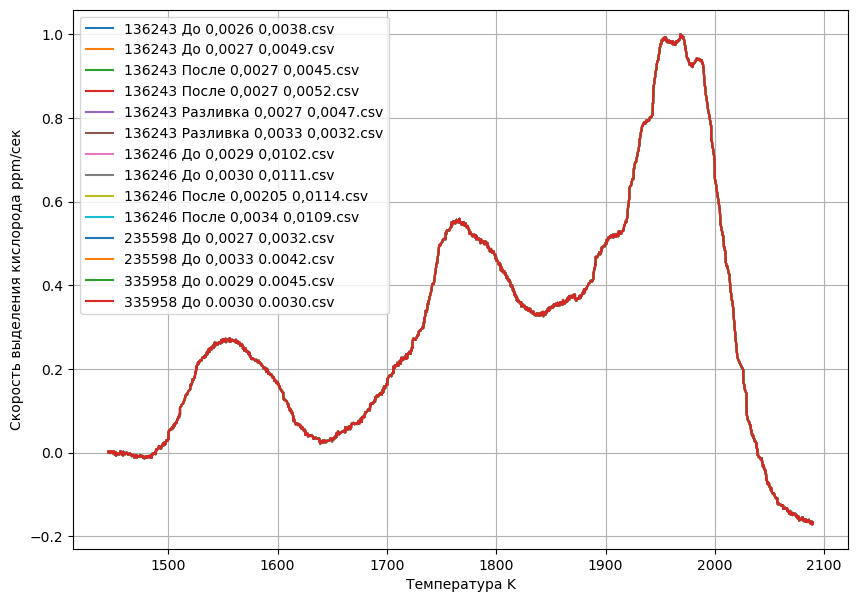

In [8]:
# fig, axes = plt.subplots(3, 1, figsize=(10, 10))
arrays = []
temps = []
files = []
for i, file in enumerate(os.listdir('data/fga-2')):
    if file in gt_files.keys():
        data = pd.read_csv('data/fga-2/' + '335989 Разливка 0.000747 0.00263.csv')
        arrays.append(data['dO3'])
        files.append(file)
        temps.append(np.interp(np.arange(len(data['dO3'])), np.arange(np.array(~data['dT1'].isna()).sum() * 10, step=10), data['dT1'][~data['dT1'].isna()].sort_values()))
plt.figure(figsize=(10, 7))
refs = []
for file, array, temp in zip(files, arrays, temps):
    plt.plot(temp + 273, array / array.max(), label=file)
    # print(array.shape, temp.shape, print(array.max()))
    refs.append((array / array.max(), temp, array.max(), file))
plt.grid(True)
plt.xlabel('Температура K')
plt.ylabel('Скорость выделения кислорода ppm/сек')
plt.legend()
plt.show()

In [9]:
matplotlib.rcParams['figure.dpi'] = 100

In [10]:
import random

def gen_gauss(size, sigma):
    mean = size // 2
    x = np.arange(0, size)
    return np.exp(-(x - mean) ** 2 / (2 * sigma ** 2)) / (sigma * (2 * np.pi) ** 0.5)

def generate_example(oxide_params, n_ref):
    with torch.no_grad():
        gauss = gen_gauss(1000, 10)
        
        keys =  list(oxide_params.keys()) 
        oxide_models = {}
    
        for oxide_name, oxide in oxide_params.items():
            e_var = np.random.randint(50000, 90000)
            e_scale = 100000
            v_var = np.random.rand()
            v_scale = 1
            t_max_delta = 30
            t_max_delta_scale = 10
            t_beg_delta = 30
            t_beg_delta_scale = 10
            oxide_models[oxide_name] = OxideModel({'init': e_var,
                                                   'scale': e_scale,},
                                                  {'init': v_var,
                                                   'scale': v_scale,},
                                                  {'init': oxide["Tm"],
                                                   'delta': t_max_delta,
                                                   'delta_scale' : t_max_delta_scale},
                                                  {'init': oxide["Tb"],
                                                   'delta': t_beg_delta,
                                                   'delta_scale' : t_beg_delta_scale},
                                                  model='first'
                                                 ).to(DEVICE)
    
        oxide_models = torch.nn.ModuleDict(oxide_models)
        t = np.linspace(1400, 2200, num=1000)
        gt = dict([(key, np.array(module(torch.tensor(t).to(DEVICE)).detach().cpu())) for key, module in oxide_models.items()])
        gt_sum = np.concatenate([np.expand_dims(x, 0) for x in gt.values()]).sum(axis=0)
        ref = [np.maximum(np.convolve(np.random.normal(gt_sum, 0.5), gauss, mode='same'), 0) for _ in range(n_ref)]
        return gt, ref, gt_sum

{'silicates': 0.0002, 'aluminates': 0.0021, 'spinel': 0.0002}
(3400,) (3400,)
3400
[3.00955936e-04 3.42421075e-04 3.57529036e-04 3.86213947e-04
 5.40479860e-04 1.04967098e-03 2.31002298e-03 4.90173751e-03
 9.52549155e-03 1.68485812e-02 2.73259447e-02 4.11002641e-02
 5.80280030e-02 7.77671849e-02 9.98172840e-02 1.23477634e-01
 1.47803574e-01 1.71662358e-01 1.93903634e-01 2.13559340e-01
 2.29969273e-01 2.42791592e-01 2.51933285e-01 2.57464807e-01
 2.59561401e-01 2.58477315e-01 2.54538764e-01 2.48136256e-01
 2.39694683e-01 2.29606047e-01 2.18138103e-01 2.05370619e-01
 1.91221904e-01 1.75587053e-01 1.58534791e-01 1.40455287e-01
 1.22064407e-01 1.04250909e-01 8.78478348e-02 7.34505428e-02
 6.13663196e-02 5.16965131e-02 4.44756722e-02 3.97635973e-02
 3.76233959e-02 3.80074752e-02 4.06546084e-02 4.51026796e-02
 5.08332432e-02 5.74610859e-02 6.48520849e-02 7.31104696e-02
 8.24644718e-02 9.31318124e-02 1.05235668e-01 1.18782631e-01
 1.33657124e-01 1.49590983e-01 1.66139088e-01 1.82751545e-01
 1

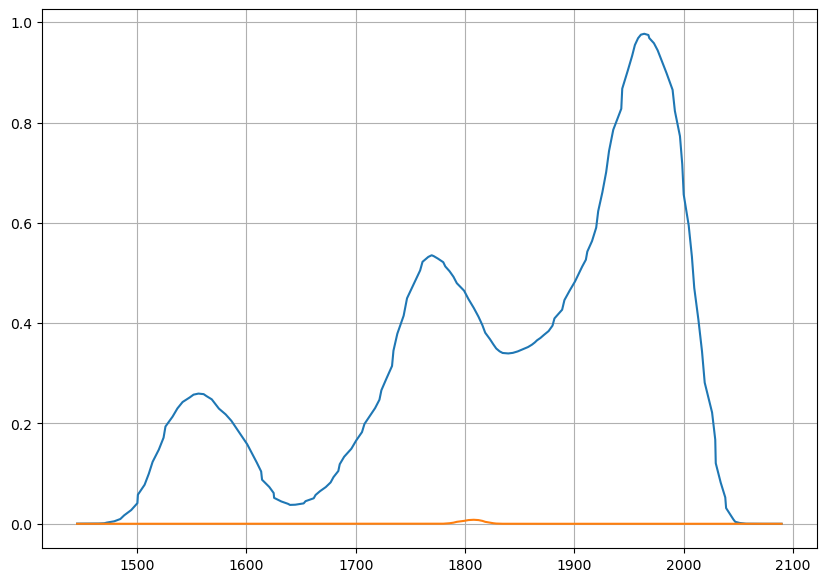

[1769.45 1963.91]


In [86]:
ref = refs[0]
print(gt_files[ref[3]])
print(ref[1].shape, ref[0].shape)
temp_step = 20
t = (np.sort(ref[1]) + 273)[::temp_step]
gauss = gen_gauss(len(ref[0]), 50)
print(len(gauss))
delta = torch.zeros(len(ref[0]))
delta[len(ref[0]) // 2] = 1
smoothed_mean = np.convolve(np.maximum(np.nan_to_num(ref[0]), 0), gauss, mode='same')[::temp_step]
print(smoothed_mean)
print(t.shape, smoothed_mean.shape)
peaks = scipy.signal.find_peaks(smoothed_mean, height=0.5, distance=50)
peaks = peaks[0]#[np.argmax(peaks[1]['peak_heights']):np.argmax(peaks[1]['peak_heights']) + 1]
print(peaks)
plt.figure(figsize=(10, 7))
plt.plot(t, smoothed_mean)
# plt.scatter(t[peaks], smoothed_mean[peaks])
plt.grid(True)
plt.show()
peak_temp = t[peaks]
print(peak_temp)
solution_values_array = (torch.tensor(smoothed_mean), torch.tensor(t))

In [11]:
 def gen_gauss(size, sigma):
    mean = size // 2
    x = np.arange(0, size)
    return np.exp(-(x - mean) ** 2 / (2 * sigma ** 2)) / (sigma * (2 * np.pi) ** 0.5)

def reference_read(path, config):
    temp_step = config['temp_step']
    sigma = config['reference_sigma']
    data = pd.read_csv(path)
    values = data['dO3']
    total_oxygen = float(os.path.basename(path).split()[2].replace(',', '.'))
    temp = np.interp(np.arange(len(data['dO3'])), np.arange(np.array(~data['dT1'].isna()).sum() * 10, step=10), data['dT1'][~data['dT1'].isna()].sort_values())
    temp = (np.sort(temp) + 273)[::temp_step]
    gauss = gen_gauss(len(values), sigma)
    smoothed_mean = np.convolve(np.maximum(np.nan_to_num(values), 0), gauss, mode='same')[::temp_step]
    v_max = smoothed_mean.max()

    return torch.tensor(smoothed_mean / v_max, requires_grad=False), torch.tensor(temp, requires_grad=False), v_max, total_oxygen
with open("config.json", 'r') as f:
    config = json.load(f)
solution_values_array = reference_read("data/fga-2/136243 Разливка 0,0027 0,0047.csv", config)[:2]

In [89]:
# with open('config.json', 'w') as f:
#     json.dump(dict(
#         gauranteed_oxides = [
#             "Al2O3",
#             "SiO2",
#         ],
#         oxide_groups = {
#             'silicates':
#                 [
#                     'MnSiO3', 'Mn2SiO4', 'SiO2', 'MgSiO3',
#                 ],
#             'aluminates':
#                 [
#                     "Al2TiO5","Al2SiO5","Al6Si2O13","MnAl2O4", "Al2O3",
#                 ],
#             'spinel':
#                 [
#                     'MgAl2O4', 'Mg2SiO4', 'CaAl4O7', 'CaAl2O4', 'Ca2SiO4', 'MgO', 'CaO',
#                 ]
#         },
#         t_begin_weight = 5e1,
#         oxide_usage_weight = 15e-2,
#         guaranteed_usage_weight = 2e-3,
#         residual_weight = 1e1,
#         t_begin_change_weight = 5e-3,
#         e_var = 80000,
#         e_scale = 500000,
#         v_scale = 1,
#         t_max_delta = 30,
#         t_max_delta_scale = 1e1,
#         t_beg_delta = 20,
#         t_beg_delta_scale = 1e1 ,
#         optim = 'RMSprop',
#         optim_params=dict(lr=0.001, momentum=0.7),
#         num_epoch = 5000,
#         stop_after = 100,
#         eval_every = 20,
#         show_every = 1000,
#         delete_after = 1000,
#         stop_eps = 1e-10,
#         max_nonmonotonic_sequence = 5 ,
#         
#     ), f)

136243 После 0,0027 0,0045.csv


 24%|██▍       | 596/2500 [00:24<00:59, 32.23it/s]

Stopping training as all oxides are oscillating. Last Epoch: 587


 27%|██▋       | 687/2500 [00:27<01:13, 24.70it/s]


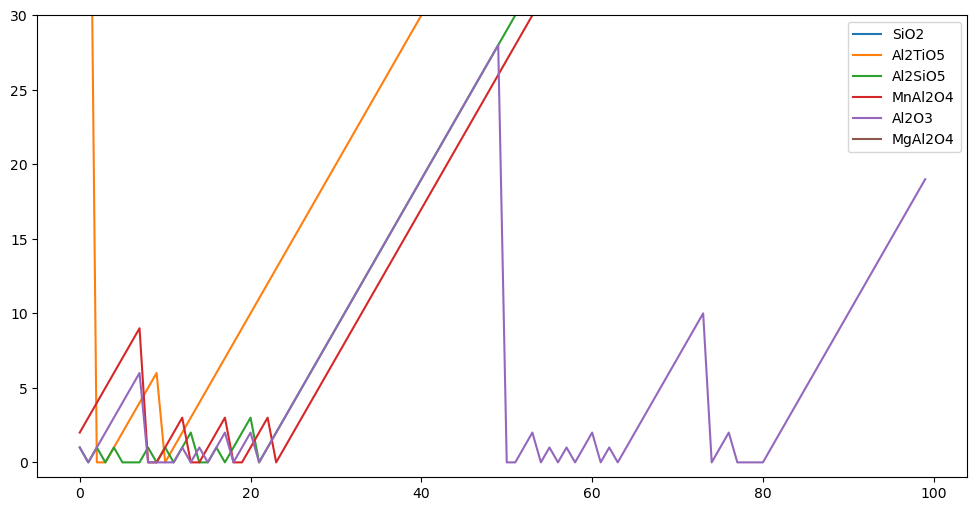

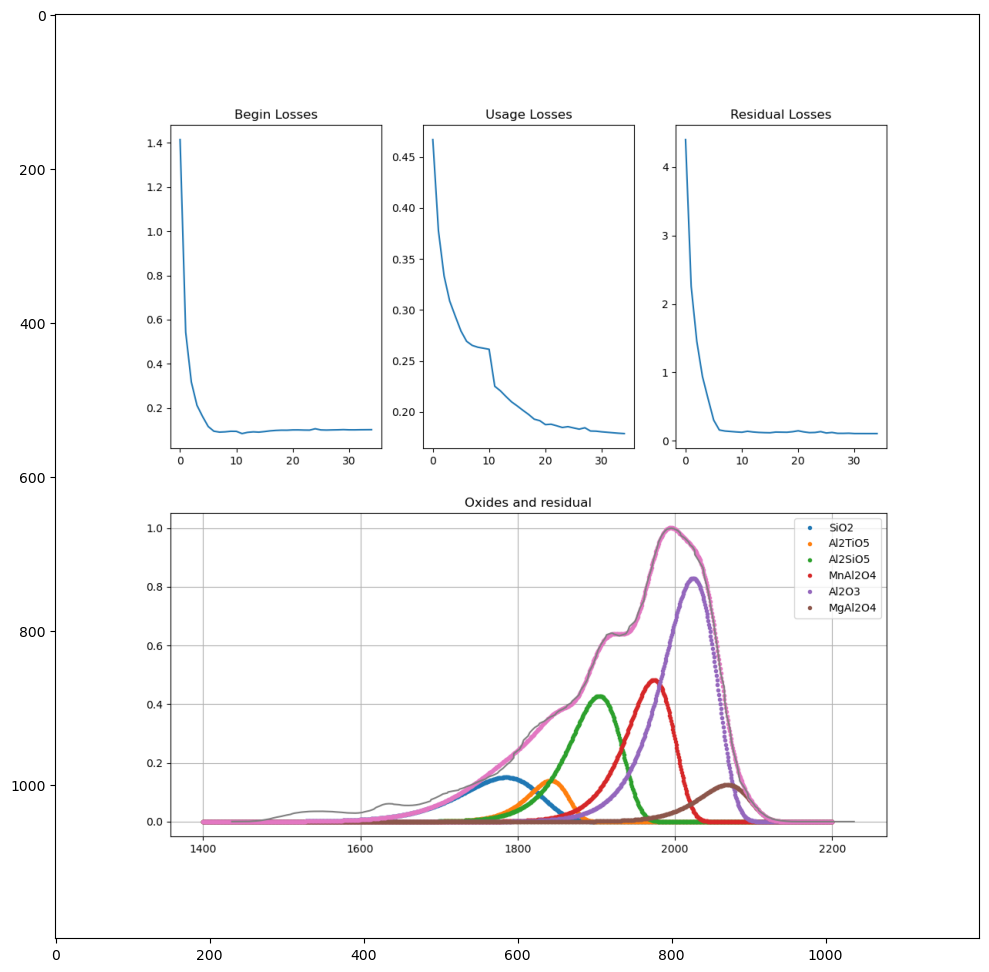

SiO2:
	T_beg_init = 1593 T_beg_final = 1622.9791949081668
	T_max_init = 1743 T_max_final = 1772.9791949081668
	V_max_init = 0.1286539365066109 V_max_final = 0.1512846814735449
	E_init = 80000 E_final = 63055.23392633178

Al2TiO5:
	T_beg_init = 1722 T_beg_final = 1700.2560874809972
	T_max_init = 1852 T_max_final = 1830.1648528588207
	V_max_init = 0.3772909679437403 V_max_final = 0.1403634946742332
	E_init = 80000 E_final = 134325.17735189758

Al2SiO5:
	T_beg_init = 1768 T_beg_final = 1742.746109054631
	T_max_init = 1898 T_max_final = 1891.7479208527773
	V_max_init = 0.5626410088636229 V_max_final = 0.4282952511996424
	E_init = 80000 E_final = 110210.87962366227

MnAl2O4:
	T_beg_init = 1807 T_beg_final = 1812.643528838076
	T_max_init = 1937 T_max_final = 1961.0953400569194
	V_max_init = 0.6400754035038546 V_max_final = 0.48300210685916095
	E_init = 80000 E_final = 128772.69017687734

Al2O3:
	T_beg_init = 1864 T_beg_final = 1861.6987764983955
	T_max_init = 1994 T_max_final = 2011.26679403

In [40]:
with open("config.json", 'r') as f:
    config = json.load(f)
with open('params.json', 'r') as f:
    oxide_params = json.load(f)
from pathlib import Path
dir_path = Path("data/fga-2/")
for file in filter(lambda x: x.is_file(), dir_path.iterdir()):
    if file.name not in [
        "136243 После 0,0027 0,0045.csv",
        # "136243 После 0,0027 0,0052.csv",
        # "136246 До 0,0029 0,0102.csv",
        # "136246 До 0,0030 0,0111.csv",
        # "136246 После 0,00205 0,0114.csv",
        # "136246 Разливка 0,0024 0,00356.csv",
        # "235598 До 0,0033 0.0042.csv",
        # "335989 Разливка 0.000747 0.00263.csv",
        # "336013 До 0.0030 0.00325.csv",
        # "336013 Разливка 0.00256 0.00346.csv",
        # "235598 звезда 0,0031 0,0047.csv",
    ]:
        continue
    print(file.name)
    reference = reference_read(file, config)
    oxygen, time = reference[:2]
    oxide_models = {}
    global_shift_delta = torch.nn.parameter.Parameter(torch.tensor([0], dtype=torch.float64), requires_grad=True)
    for oxide_name, oxide in oxide_params.items():
    
        e_var = config['e_var']
        e_scale = config['e_scale']
        v_var = max(0, oxygen[np.argmin(np.abs(time - oxide['Tm']))])
        v_scale = config['v_scale']
        t_max_delta = config['t_max_delta']
        t_max_delta_scale = config['t_max_delta_scale']
        t_beg_delta = config['t_beg_delta']
        t_beg_delta_scale = config['t_beg_delta_scale']
        if v_var < 0.01:
            continue
        oxide_models[oxide_name] = OxideModel(
            {'init': e_var,
             'scale': e_scale, },
            {'init': v_var,
             'scale': v_scale, },
            {'init': oxide["Tm"],
             'delta': t_max_delta,
             'delta_scale': t_max_delta_scale},
            {'init': oxide["Tb"],
             'delta': t_beg_delta,
             'delta_scale': t_beg_delta_scale},
            model=config['model']
        )
    
    oxide_models = torch.nn.ModuleDict(oxide_models)
    import torch.optim
    
    optimizer = getattr(torch.optim, config['optim'])([x for x in oxide_models.parameters()] + [global_shift_delta], **config['optim_params'])
    
    train(oxide_models, global_shift_delta, reference[:2], optimizer, config)

In [14]:
def temperature_shift(delta, max_delta=30, delta_scale=1):
    return max_delta * (2 * torch.nn.functional.sigmoid(delta * delta_scale) - 1)
oxide_models = {}
# t_begin_weight = 5e1
# oxide_usage_weight = 15e-2
# guaranteed_usage_weight = 2e-3
# residual_weight = 1e1
# t_begin_change_weight = 0.005

oxygen, time = deepcopy(solution_values_array)
global_shift_delta = torch.nn.parameter.Parameter(torch.tensor([0], dtype=torch.float64, device=DEVICE), requires_grad=True)

for oxide_name, oxide in oxide_params.items():

    # if not any(abs(oxide['Tm'] - x) <= peak_epsilon for x in peak_temp):
    #     continue
    
    e_var = config['e_var']
    e_scale = config['e_scale']
    v_var = max(0, oxygen[np.argmin(np.abs(t - oxide['Tm']))])
    v_scale = config['v_scale']
    t_max_delta = config['t_max_delta']
    t_max_delta_scale = config['t_max_delta_scale']
    t_beg_delta = config['t_beg_delta']
    t_beg_delta_scale = config['t_beg_delta_scale']
    if v_var < 0.01:
        continue
    oxide_models[oxide_name] = OxideModel(
        {'init': e_var,
         'scale': e_scale,},
        {'init': v_var,
         'scale': v_scale,},
        {'init': oxide["Tm"],
         'delta': t_max_delta,
         'delta_scale' : t_max_delta_scale},
        {'init': oxide["Tb"],
         'delta': t_beg_delta,
         'delta_scale' : t_beg_delta_scale},
        model='first'
        ).to(DEVICE)

oxide_models = torch.nn.ModuleDict(oxide_models)
print([x for x in oxide_models.named_parameters()]+ [global_shift_delta.data])
optimizer = torch.optim.RMSprop([x for x in oxide_models.parameters()] + [global_shift_delta], lr=0.001, momentum=0.7)

train(oxide_models, global_shift_delta, solution_values_array, optimizer, config)

NameError: name 'oxide_params' is not defined

  0%|          | 0/5000 [00:00<?, ?it/s]

name 't_begin_change_weight' is not defined


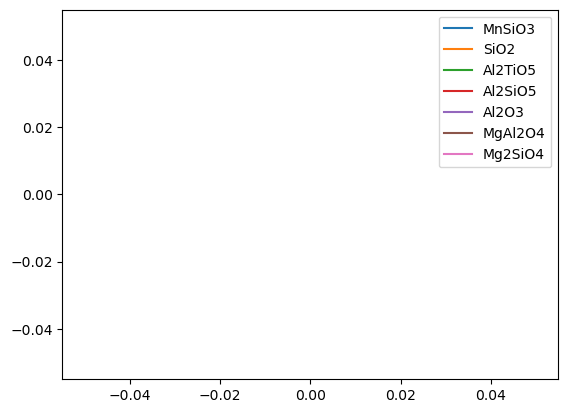

IndexError: list index out of range

In [27]:
# Train configuration
num_epoch = 5000
stop_after = 100
eval_every = 20
show_every = 500
delete_after = 1000
stop_eps = 1e-10
K = 5  # Number of iterations to check for monotonicity
window_size = 20
frames = []
begin_losses = []
residual_losses = []
usage_losses = []
# Dictionary to store last K v_max values for each oxide
oxide_direction_info = {
    oxide_name: {
        "last_direction": None,
        "iter_since_last_change": 0,
        "v_max_history": [],
        "smoothed_v_max": None,
    }
    for oxide_name in oxide_models.keys()
}
try:
    for i in tqdm.tqdm(range(num_epoch)):
        oxide_models.train()
        update_loss = []
        global_shift = temperature_shift(global_shift_delta)
        def closure():
            optimizer.zero_grad()
            oxides_to_delete = []
            loss = 0
            oxygen, time = solution_values_array
            # mask = time > 1500
            residual = oxygen
            for oxide_name, oxide in oxide_models.items():
                if oxide.get_v_max() < 0.01:
                    oxides_to_delete.append(oxide_name)
                    continue
            for oxide_name, oxide in oxide_models.items():
                Value = oxide(time, global_shift)
                # T_beg loss
                TB = oxide.get_t_beg() + global_shift
                begin_sigmoid = 1 / (1 + torch.exp(time - TB)) # Gives smooth "time < TB" function
                if oxide.get_v_max() < 0.2 or i < 200:
                    begin_sigmoid = begin_sigmoid.detach()
                begin_loss = torch.mean(Value * begin_sigmoid)
                begin_change_loss = t_begin_change_weight * torch.abs(oxide.T_beg_delta)
                # Usage loss
                usage_loss = 0
                if oxide_name not in gauranteed_oxides:
                    usage_loss = oxide_usage_weight * oxide.get_v_max()
                else:
                    usage_loss = guaranteed_usage_weight * oxide.get_v_max()
                loss += usage_loss + t_begin_weight * begin_loss + begin_change_loss
                # Residual loss
                residual = residual - Value
            
            loss += residual_weight * torch.mean(torch.abs(residual))
            loss.backward(retain_graph=True)
            # Delete small oxides
            for oxide in oxides_to_delete:
                oxide_models.pop(oxide)
            return loss
        optimizer.step(closure)
        if i == 200:
            for g in optimizer.param_groups:
                g['lr'] = 0.01
        if i == 2000:
            for g in optimizer.param_groups:
                g['momentum'] = 0.9
                
        # Check for oscillations in v_max
        any_stable = False  # At least one oxide is not oscillating
        for oxide_name, oxide in oxide_models.items():
            current_v_max = oxide.get_v_max().item()
            oxide_direction_info[oxide_name]["v_max_history"].append(current_v_max)
            
            if len(oxide_direction_info[oxide_name]["v_max_history"]) <= window_size:
                any_stable = True
                continue
            oxide_direction_info[oxide_name]["v_max_history"].pop(0)
                
            current_v_max = np.mean(oxide_direction_info[oxide_name]["v_max_history"])
            prev_v_max = oxide_direction_info[oxide_name].get("smoothed_v_max", None)
            
            if prev_v_max is not None:
                # Determine the current direction
                if current_v_max > prev_v_max:
                    current_direction = "increase"
                elif current_v_max < prev_v_max:
                    current_direction = "decrease"
                else:
                    current_direction = oxide_direction_info[oxide_name]["last_direction"]  # No change
                
                # Check if direction has changed
                if current_direction != oxide_direction_info[oxide_name]["last_direction"]:
                    # If direction changed too quickly, it's an oscillation
                    if oxide_direction_info[oxide_name]["iter_since_last_change"] < K:
                        # print(f"Oscillation detected for {oxide_name}: direction changed too frequently.")
                        pass
                    else:
                        any_stable = True  # At least one oxide is stable
                    
                    # Reset the iteration counter
                    oxide_direction_info[oxide_name]["iter_since_last_change"] = 0
                else:
                    # Increment the iteration counter
                    oxide_direction_info[oxide_name]["iter_since_last_change"] += 1
                    any_stable = True
                
                oxide_direction_info[oxide_name]["iter_since_last_change_history"].append(oxide_direction_info[oxide_name]["iter_since_last_change"])
                
                # Update the last direction
                oxide_direction_info[oxide_name]["last_direction"] = current_direction
            
            # Update the last v_max value
            oxide_direction_info[oxide_name]["smoothed_v_max"] = current_v_max
        
        # Stop training if all oxides are oscillating
        if not any_stable and i > stop_after:
            print("Stopping training as all oxides are oscillating.")
            break
            
        if i % eval_every == 0:
            fig = plt.figure(figsize=(12, 12))
            ax1 = plt.subplot(2,3,1)
            ax1.set_title('Begin Losses')
            ax2 = plt.subplot(2,3,2)
            ax2.set_title('Usage Losses')
            ax3 = plt.subplot(2,3,3)
            ax3.set_title('Residual Losses')
            ax4 = plt.subplot(2,1,2)
            ax4.set_title('Oxides and residual')
            if i % show_every == 0:
                print(f'GLOBAL SHIFT: {global_shift.item()}')
                print(f'UPDATE LOSS: {np.mean(update_loss)}')
            with torch.no_grad():
                oxide_models.eval()
                loss = torch.zeros(1)
                oxygen, time = solution_values_array
                residual = oxygen
                delete = []
                begin_loss_all = 0
                usage_loss_all = 0
                for oxide_name, oxide in oxide_models.items():
                    Value = oxide(time, global_shift)
                    TB = (oxide.get_t_beg() + global_shift).item() 
                    begin_sigmoid = 1 / (1 + torch.exp((time - TB)))
                    begin_loss = torch.mean(Value * begin_sigmoid)
                    begin_loss_all += t_begin_weight * begin_loss
                    if i % show_every == 0:
                        print(f"BEGIN {t_begin_weight * begin_loss.item()}", end=' ')
                    if oxide_name not in gauranteed_oxides:
                        usage_loss = oxide_usage_weight * oxide.get_v_max()
                    else:
                        usage_loss = guaranteed_usage_weight * oxide.get_v_max()
                    usage_loss_all += usage_loss
                    if i % show_every == 0:
                        print(f"USAGE {usage_loss.item()}")
                    loss += t_begin_weight * begin_loss + usage_loss
                    #===========DELETE TOO SMALL===============================
                    v_ref = oxygen[np.argmin(np.abs(time - oxide.get_t_max().item() - global_shift.item()))]
                    if (oxide.get_v_max() < 0.3 * v_ref and i > delete_after) or oxide.get_v_max() < 0.1 * v_ref or oxide.get_v_max() < 0.05:
                        delete.append((oxide_name, oxide.V_max))
                        
                    if i % show_every == 0:
                        print([x for x in oxide.named_parameters()])
                    residual = residual - Value
                residual_loss = residual_weight * torch.mean(torch.abs(residual))
                begin_losses.append(begin_loss_all.item())
                ax1.plot(begin_losses)
                usage_losses.append(usage_loss_all.item())
                ax2.plot(usage_losses)
                residual_losses.append(residual_loss.item())
                ax3.plot(residual_losses)
                loss += torch.mean(residual ** 2)            
                if i % show_every == 0:
                    print(f"RESIDUAL: {residual_loss.item()}")
                
                if delete:
                    sorted(delete, key=lambda x: x[1])
                    for oxide, v_max in delete:
                        oxide_models.pop(oxide)
                        if v_max > 0.05:
                            break
                time_grid = np.linspace(1400, 2200, num=1000)
                res = torch.zeros(1000).cpu()
                for oxide_name, oxide in oxide_models.items():
                    ox_res = oxide(torch.tensor(time_grid).to(DEVICE), global_shift)
                    ax4.plot(time_grid, ox_res.detach().cpu(), '.', label=oxide_name)
                    res += ox_res.cpu()
                ax4.plot(time_grid, res.detach().cpu(), '.')
                ax4.plot(time.cpu(), oxygen.cpu(), '-')
                ax4.legend()
                ax4.grid(True)
                fig.canvas.draw()
                image = Image.frombytes('RGBA', fig.canvas.get_width_height(), fig.canvas.buffer_rgba()).convert('RGB')
                frames.append(image)
                if i % show_every == 0:
                    plt.show()
                plt.close('all')
except Exception as e:
    print(e)
for oxide_name, oxide in oxide_models.items():
    plt.plot(oxide_direction_info[oxide_name]["iter_since_last_change_history"], label=oxide_name)
plt.legend()
plt.show()
gif_duration = 10 * 1000
frames[0].save('train_10_sec.gif', save_all=True, append_images=frames[1:], optimize=False, duration=min(gif_duration / len(frames), 400), loop=0)
display(frames[-1])
# frames[0].save('train_20_sec.gif', save_all=True, append_images=frames[1:], optimize=False, duration=2 * gif_duration / num_epoch, loop=0)
# frames[0].save('train_60_sec.gif', save_all=True, append_images=frames[1:], optimize=False, duration=6 * gif_duration / num_epoch, loop=0)
for oxide_name, oxide in oxide_models.items():
    print(f'{oxide_name}:\n'
          f'\tT_beg_init = {oxide.b_state["init"]} T_beg_final = {oxide.get_t_beg().item()}\n'
          f'\tT_max_init = {oxide.t_state["init"]} T_max_final = {oxide.get_t_max().item()}\n'
          f'\tV_max_init = {oxide.v_state["init"]} V_max_final = {oxide.get_v_max().item()}\n'
          f'\tE_init = {oxide.e_state["init"]} E_final = {oxide.get_E().item()}\n')

In [39]:
from OxideModel import OxideModel


def oxides_loss(oxide_models, global_shift, reference, it, config):
    oxygen, time = reference
    t_begin_weight = config['t_begin_weight']
    t_begin_change_weight = config['t_begin_change_weight']
    guaranteed_oxides = config['guaranteed_oxides']
    guaranteed_usage_weight = config['guaranteed_usage_weight']
    oxide_usage_weight = config['oxide_usage_weight']
    residual_weight = config['residual_weight']
    residual = oxygen
    begin_loss_all = 0
    usage_loss_all = 0
    begin_change_loss_all = 0
    for oxide_name, oxide in oxide_models.items():
        Value = oxide(time, global_shift)
        # T_beg loss
        TB = oxide.get_t_beg() + global_shift
        begin_sigmoid = 1 / (1 + torch.exp(time - TB))  # Gives smooth "time < TB" function
        if oxide.get_v_max() < 0.2 or it < 200:
            begin_sigmoid = begin_sigmoid.detach()
        begin_loss = t_begin_weight * torch.mean(Value * begin_sigmoid)
        begin_change_loss = t_begin_change_weight * torch.abs(oxide.T_beg_delta)
        # Usage loss
        usage_loss = 0
        if oxide_name not in guaranteed_oxides:
            usage_loss = oxide_usage_weight * oxide.get_v_max()
        else:
            usage_loss = guaranteed_usage_weight * oxide.get_v_max()
        begin_change_loss_all += begin_change_loss
        begin_loss_all += begin_loss
        usage_loss_all += usage_loss
        # Residual loss
        residual = residual - Value
    residual_loss = residual_weight * torch.mean(torch.abs(residual))
    return begin_change_loss_all, begin_loss_all, usage_loss_all, residual_loss

def temperature_shift(delta, max_delta=30, delta_scale=1):
    return max_delta * (2 * torch.nn.functional.sigmoid(delta * delta_scale) - 1)

def draw(oxide_models, global_shift, reference, it, config, begin_losses, usage_losses, residual_losses):
    fig = plt.figure(figsize=(12, 12))
    begin_loss_ax = plt.subplot(2, 3, 1)
    begin_loss_ax.set_title('Begin Losses')
    usage_loss_ax = plt.subplot(2, 3, 2)
    usage_loss_ax.set_title('Usage Losses')
    residual_loss_ax = plt.subplot(2, 3, 3)
    residual_loss_ax.set_title('Residual Losses')
    oxides_ax = plt.subplot(2, 1, 2)
    oxides_ax.set_title('Oxides and residual')
    logs = [f'GLOBAL SHIFT: {global_shift.item()}']

    oxygen, time = reference

    with (torch.no_grad()):
        oxide_models.eval()
        begin_change_loss, begin_loss, usage_loss, residual_loss = \
            oxides_loss(oxide_models, global_shift, reference, it, config)
        begin_losses.append(begin_loss.item() + begin_change_loss.item())
        begin_loss_ax.plot(begin_losses)
        usage_losses.append(usage_loss.item())
        usage_loss_ax.plot(usage_losses)
        residual_losses.append(residual_loss.item())
        residual_loss_ax.plot(residual_losses)
        loss = sum([begin_change_loss, begin_loss, usage_loss, residual_loss])
        time_grid = np.linspace(1400, 2200, num=1000)
        res = torch.zeros(1000).cpu()
        for oxide_name, oxide in oxide_models.items():
            oxide_parameters = "\n\t".join([f"{x[0]} = {x[1].item()}" for x in oxide.named_parameters()])
            logs.append(f'{oxide_name}: {oxide_parameters}')
            ox_res = oxide(torch.tensor(time_grid), global_shift)
            oxides_ax.plot(time_grid, ox_res.detach(), '.', label=oxide_name)
            res += ox_res.cpu()
        oxides_ax.plot(time_grid, res.detach(), '.')
        oxides_ax.plot(time, oxygen, '-')
        oxides_ax.legend()
        oxides_ax.grid(True)
        logs = '\n'.join(logs)
        return fig, logs


def delete_oxides(oxide_models, global_shift, reference, it, config):
    oxygen, time = reference
    delete = []
    delete_after = config['delete_after']

    for oxide_name, oxide in oxide_models.items():
        v_ref = oxygen[np.argmin(np.abs(time - oxide.get_t_max().item() - global_shift.item()))]
        if (
                oxide.get_v_max() < 0.3 * v_ref and it > delete_after) or oxide.get_v_max() < 0.1 * v_ref or oxide.get_v_max() < 0.05:
            delete.append(oxide_name)

    from itertools import combinations
    for oxide_1, oxide_2 in combinations(oxide_models.items(), 2):
        oxide_name_1, oxide_1 = oxide_1
        oxide_name_2, oxide_2 = oxide_2
        if oxide_name_1 in delete or oxide_name_2 in delete:
            continue
        if abs(oxide_1.get_t_max().item() - oxide_2.get_t_max().item()) < 20:
            if abs(oxide_2.get_v_max()) < abs(oxide_1.get_v_max()) or oxide_1 in config['guaranteed_oxides']:
                delete.append(oxide_name_2)
            else:
                delete.append(oxide_name_1)
    for oxide in delete:
        oxide_models.pop(oxide)


def train(oxide_models, global_shift_delta, reference, optimizer, config):

    # Train configuration
    num_epoch = config['num_epoch']
    stop_after = config['stop_after']
    draw_every = config['draw_every']
    show_every = config['show_every']
    delete_after = config['delete_after']
    unstable_after = config['unstable_after']  # Number of iterations to check for monotonicity
    stable_after = config['stable_after']
    max_instability_duration = config['instability_duration']
    window_size = config['window_size']
    frames = []
    begin_losses = []
    residual_losses = []
    usage_losses = []
    # Dictionary to store last K v_max values for each oxide
    oxide_direction_info = {
        oxide_name: {
            "last_direction": None,
            "iter_since_last_change": 0,
            "v_max_history": [],
            "smoothed_v_max": None,
            "is_stable": True,
            "iter_since_last_change_history": [],
        }
        for oxide_name in oxide_models.keys()
    }
    instability_duration = 0
    timer = None
    try:
        for it in tqdm.tqdm(range(num_epoch)):
            oxide_models.train()
            global_shift = temperature_shift(global_shift_delta)
    
            def closure():
                optimizer.zero_grad()
    
                oxides_to_delete = []
                for oxide_name, oxide in oxide_models.items():
                    if oxide.get_v_max() < 0.01:
                        oxides_to_delete.append(oxide_name)
                for oxide in oxides_to_delete:
                    oxide_models.pop(oxide)
    
                begin_change_loss, begin_loss, usage_loss, residual_loss = oxides_loss(oxide_models, global_shift, reference, it, config)
                loss = begin_change_loss + begin_loss + usage_loss + residual_loss
                loss.backward(retain_graph=True)
                return loss
    
            optimizer.step(closure)
            if it == 200:
                for g in optimizer.param_groups:
                    g['lr'] = 0.01
            
            if it == 1500:
                for g in optimizer.param_groups:
                    g['lr'] = 0.001
    
            # Check for oscillations in v_max
            any_stable = False  # At least one oxide is not oscillating
            for oxide_name, oxide in oxide_models.items():
                current_v_max = oxide.get_v_max().item()
                if current_v_max < 0.2:
                    continue
                oxide_direction_info[oxide_name]["v_max_history"].append(current_v_max)
    
                if len(oxide_direction_info[oxide_name]["v_max_history"]) <= window_size:
                    any_stable = True
                    continue
                oxide_direction_info[oxide_name]["v_max_history"].pop(0)
    
                current_v_max = np.mean(oxide_direction_info[oxide_name]["v_max_history"])
                prev_v_max = oxide_direction_info[oxide_name].get("smoothed_v_max", None)
    
                if prev_v_max is not None:
                    # Determine the current direction
                    if current_v_max > prev_v_max:
                        current_direction = "increase"
                    elif current_v_max < prev_v_max:
                        current_direction = "decrease"
                    else:
                        current_direction = oxide_direction_info[oxide_name]["last_direction"]  # No change
    
                    # Check if direction has changed
                    if current_direction != oxide_direction_info[oxide_name]["last_direction"]:
                        # If direction changed too quickly, it's an oscillation
                        if oxide_direction_info[oxide_name]["iter_since_last_change"] < unstable_after:
                            oxide_direction_info[oxide_name]["is_stable"] = False
    
                        # Reset the iteration counter
                        oxide_direction_info[oxide_name]["iter_since_last_change"] = 0
                    else:
                        # Increment the iteration counter
                        oxide_direction_info[oxide_name]["iter_since_last_change"] += 1
                    
                    if oxide_direction_info[oxide_name]["iter_since_last_change"] > stable_after:
                        oxide_direction_info[oxide_name]["is_stable"] = True
    
                    # Update the last direction
                    oxide_direction_info[oxide_name]["last_direction"] = current_direction
                    oxide_direction_info[oxide_name]["iter_since_last_change_history"].append(oxide_direction_info[oxide_name]["iter_since_last_change"])
                    
                # Update the last v_max value
                oxide_direction_info[oxide_name]["smoothed_v_max"] = current_v_max
                if oxide_direction_info[oxide_name]["is_stable"]:
                    any_stable = True
    
            if not any_stable:
                instability_duration += 1
            else:
                instability_duration = 0

            # Stop training if all oxides are oscillating
            if instability_duration >= max_instability_duration and it > stop_after and timer is None:
                print(f"Stopping training as all oxides are oscillating. Last Epoch: {it}")
                for g in optimizer.param_groups:
                    g['lr'] = 0.001
                timer = 100
            if timer is not None:
                if timer == 0:
                    break
                timer -= 1
            delete_oxides(oxide_models, global_shift, reference, it, config)
            if it % draw_every == 0:
                fig, logs = draw(oxide_models, global_shift, reference, it, config, begin_losses, usage_losses,
                                 residual_losses)

                if show_every and it % show_every == 0:
                    print(logs)
                    plt.show()
                fig.canvas.draw()
                image = Image.frombytes('RGBA', fig.canvas.get_width_height(), fig.canvas.buffer_rgba()).convert('RGB')
                frames.append(image)
                plt.close('all')
    
    except Exception as e:
        print(e)
    fig = plt.figure(figsize=(12, 6))
    fig.set_dpi(100)
    for oxide_name, oxide in oxide_models.items():
        plt.plot(oxide_direction_info[oxide_name]["iter_since_last_change_history"][-100:], label=oxide_name)
    plt.ylim([-1, 30])
    plt.legend()
    plt.show()
    
    gif_duration = 10 * 1000
    frames[0].save('train_10_sec.gif', save_all=True, append_images=frames[1:], optimize=False,
                   duration=min(gif_duration / len(frames), 100), loop=0)
    fig = plt.figure(figsize=(12, 12))
    fig.set_dpi(100)
    plt.imshow(frames[-1])
    plt.show()
    for oxide_name, oxide in oxide_models.items():
        print(f'{oxide_name}:\n'
              f'\tT_beg_init = {oxide.b_state["init"]} T_beg_final = {oxide.get_t_beg().item()}\n'
              f'\tT_max_init = {oxide.t_state["init"]} T_max_final = {oxide.get_t_max().item()}\n'
              f'\tV_max_init = {oxide.v_state["init"]} V_max_final = {oxide.get_v_max().item()}\n'
              f'\tE_init = {oxide.e_state["init"]} E_final = {oxide.get_E().item()}\n')

In [ ]:
# oxide_params = {
#     "Cr2O3": {"Tb": 1138, "Tm": 1268},
#     "TiO": {"Tb": 1350, "Tm": 1480},
#     "MnO": {"Tb": 1357, "Tm": 1487},
#     "Ti2O3": {"Tb": 1489, "Tm": 1619},
#     "TiO2": {"Tb": 1490, "Tm": 1620},
#     "Ti3O5": {"Tb": 1502, "Tm": 1633},
#     "MnSiO3": {"Tb": 1508, "Tm": 1639},
#     "Mn2SiO4": {"Tb": 1523, "Tm": 1653}, # 2
#     "SiO2": {"Tb": 1587, "Tm": 1718},
#     "Al2TiO5": {"Tb": 1697, "Tm": 1827},
#     "Al2SiO5": {"Tb": 1727, "Tm": 1857},
#     "Al6Si2O13": {"Tb": 1753, "Tm": 1884},
#     "MnAl2O4": {"Tb": 1772, "Tm": 1902},
# #     "Al2O3": {"Tb": 1799, "Tm": 1930},
#     "Al2O3": {"Tb": 1701, "Tm": 1831},
#     "MgSiO3": {"Tb": 1804, "Tm": 1934},
#     "MgAl2O4": {"Tb": 1852, "Tm": 1982},
#     "CaAl4O7": {"Tb": 1915, "Tm": 2045}, # 2
#     "Mg2SiO4": {"Tb": 1923, "Tm": 2054},
#     "CaAl2O4": {"Tb": 1956, "Tm": 2086},
#     "Ca2SiO4": {"Tb": 2093, "Tm": 2223},
#     "MgO": {"Tb": 2107, "Tm": 2237},
#     "CaO": {"Tb": 2165, "Tm": 2295},
# }
for oxide_name, oxide in oxide_params.items():
    # if oxide_name in oxide_models.keys():
    #     continue
    if not any(abs(oxide['Tm'] - x) <= peak_epsilon for x in peak_temp):
        continue
    e_var = 60000
    e_scale = 100000 
    v_var = 1
    v_scale = 1
    t_max_delta = 10
    t_max_delta_scale = 10
    t_beg_delta = 10
    t_beg_delta_scale = 10
    oxide_models[oxide_name] = OxideModel({'init': e_var ,
                                           'scale': e_scale,},
                                          {'init': smoothed_mean[np.argmin(np.abs(t - oxide['Tm'] - 50))]  + 0.18,
                                           'scale': v_scale,},
                                          {'init': oxide["Tm"] + 50,
                                           'delta': t_max_delta,
                                           'delta_scale' : t_max_delta_scale},
                                          {'init': oxide["Tb"],
                                           'delta': t_beg_delta,
                                           'delta_scale' : t_beg_delta_scale},
                                          model='first'
                                         ).to(DEVICE)
    param_group = optimizer.param_groups[0]
    param_group['params'] =  [p for p in oxide_models[oxide_name].parameters()]
    param_group['lr'] = 0.1
    optimizer.param_groups.append(param_group)
print([x for x in oxide_models.named_parameters()])

In [ ]:
grid = np.linspace(0, 448.9, num=1000)
oxygen, time = solution_values_array
res = []
for name, oxide in oxide_models.items():
    ans = []
    global_shift = temperature_shift(global_shift_delta)
    def time_to_temp(time):
        t = solution_values_array[1]
        return oxide(torch.tensor(t[int(time * 10 / temp_step):int(time * 10 / temp_step)+1]), global_shift)
    for time in grid:
        ans.append(time_to_temp(time).item())
    res.append(ans)
for ans in res:
    plt.plot(grid, ans)
plt.grid(True)

In [ ]:
sum = 0
grid = np.linspace(0, 448.9, num=1000)
group_oxygen = dict([(key, 0) for key in oxide_groups.keys()])
oxides_count = {}
for name, oxide in oxide_models.items():
    global_shift = temperature_shift(global_shift_delta)
    def time_to_temp(time):
        t = solution_values_array[1]
        return oxide(torch.tensor(t[int(time * 10 / temp_step):int(time * 10 / temp_step)+1]), global_shift)
    y = []
    for time in grid:
        y.append(time_to_temp(time).item())
    # integral = quad(oxide, 1400, 2200)[0]
    integral = scipy.integrate.simpson(np.array(y), grid) * ref[2] / 1.6e6
    for key, value in oxide_groups.items():
        if name in value:
            group_oxygen[key] += integral
    oxides_count[name] = integral
total_oxygen = float(ref[-1].split()[2].replace(',', '.'))
total_oxygen_integrate = scipy.integrate.simpson(solution_values_array[0], np.linspace(0, 448.9, num=len(solution_values_array[0]))) * ref[2] / 1.6e6
for name, value in oxides_count.items():
    oxides_count[name] = value * total_oxygen / total_oxygen_integrate
    sum += oxides_count[name]
    print(name, oxides_count[name])
    

print(ref[-1])
print(f'SUM {sum}')
for key, value in group_oxygen.items():
    print(f'{key} {value}')

In [ ]:
def one_ref(params, smoothed_mean, Time, v_max, oxide_params):
    oxide_models = {}
    solution_values_array = [(smoothed_mean, Time)]
    for oxide_name, oxide in oxide_params.items():
    
        e_var = params['e']
        e_scale = params['es']
        v_scale = params['vs']
        t_max_delta = 30
        t_max_delta_scale = params['tms']
        t_beg_delta = 30
        t_beg_delta_scale = params['tbs']
        oxide_models[oxide_name] = OxideModel({'init': e_var,
                                               'scale': e_scale,},
                                              {'init': smoothed_mean[np.argmin(np.abs(Time - oxide['Tm']))],
                                               'scale': v_scale,},
                                              {'init': oxide["Tm"],
                                               'delta': t_max_delta,
                                               'delta_scale' : t_max_delta_scale},
                                              {'init': oxide["Tb"],
                                               'delta': t_beg_delta,
                                               'delta_scale' : t_beg_delta_scale},
                                              model='first'
                                             ).to(DEVICE)
    global_shift_delta = torch.nn.parameter.Parameter(torch.tensor([0.01], dtype=torch.float64))

    oxide_models = torch.nn.ModuleDict(oxide_models)
    optimizer = torch.optim.SGD([x for x in oxide_models.parameters()] + [global_shift_delta], lr=params['lr'])
    
    num_epoch = params['num_epoch']
    eval_every = params['eval_epoch']
    delete_after = params['del_epoch']
    stop_eps = params['stop_eps'] / params['lr']
    t_begin_weight = params['beg_w']
    oxide_usage_weight = params['use_w']
    
    for i in range(int(num_epoch)):
        oxide_models.train()
        optimizer.zero_grad()
        update_loss = []
        global_shift = temperature_shift(global_shift_delta)
        def closure():
            loss = 0
            for oxide_name, oxide in oxide_models.items():
                TB = (oxide.get_t_beg() + global_shift).item() 
                begin_grid = torch.linspace(1400, TB, 50).to(DEVICE)
                begin_loss = torch.mean(oxide(begin_grid, global_shift)[1])
                update_loss.append(oxide.update_loss().detach().cpu().numpy())
                usage_loss = 0
                if oxide_name not in gauranteed_oxides:
                    usage_loss = oxide_usage_weight * oxide.V_max
                loss += t_begin_weight * begin_loss + old_oxides_w * oxide.update_loss_old().to(DEVICE) + usage_loss
                oxide.save()
                
            for oxygen, time in solution_values_array:
                mask = time > 1500
                residual = oxygen[mask]
                for oxide_name, oxide in oxide_models.items():
                    
                    Value = oxide(time[mask], global_shift)
                    residual = residual - Value
                loss += torch.mean(residual ** 2)
            loss = loss / len(solution_values_array)
            loss.backward()
            return loss
        closure()
        # torch.nn.utils.clip_grad_norm_(oxide_models.parameters(), 10)
        optimizer.step()
        if np.mean(update_loss) < stop_eps and i > eval_every:
            break
        if i % eval_every == 0:
            with torch.no_grad():
                oxide_models.eval()
                loss = torch.zeros(1)
                delete = []
                for oxide_name, oxide in oxide_models.items():
                    TB = (oxide.get_t_beg() + global_shift).item() 
                    begin_grid = torch.linspace(1400, TB, 50).to(DEVICE)
                    begin_loss = torch.mean(oxide(begin_grid, global_shift)[1])
                    update_loss = oxide.update_loss_old()
                    loss += t_begin_weight * begin_loss
                    #===========DELETE TOO SMALL===============================
                    if (oxide.get_v_max() < 0.05 and i > delete_after) or oxide.get_v_max() < 0.01:
                        delete.append((oxide_name, oxide.V_max))
        
                if delete:
                    sorted(delete, key=lambda x: x[1])
                    for oxide, v_max in delete:
                        oxide_models.pop(oxide)
                        if v_max > 0.05:
                            break
                            
    sum = 0
    grid = np.linspace(0, 448.9, num=1000)
    group_oxygen = dict([(key, 0) for key in oxide_groups.keys()])
    for name, oxide in oxide_models.items():
        global_shift = temperature_shift(global_shift_delta)
        def time_to_temp(t):
            return oxide(torch.tensor(Time[int(t * 10):int(t * 10)+1]), global_shift)
        y = []
        for t in grid:
            y.append(time_to_temp(t).item())
        # integral = quad(oxide, 1400, 2200)[0]
        integral = scipy.integrate.simpson(np.array(y), grid) * v_max / (params['mass'] * 1e6)
        sum += integral
        for key, value in oxide_groups.items():
            if name in value:
                group_oxygen[key] += integral
    
    return group_oxygen

def objective(params, solution_values_array, oxide_params):
    loss = 0
    values, temps, v_max, file =  random.choice(solution_values_array)
    gauss = gen_gauss(len(values), 50)
    smoothed_mean = np.convolve(values, gauss, mode='same')
    try:
        res = one_ref(params, torch.tensor(smoothed_mean), torch.tensor(temps), v_max, oxide_params)
    except Exception as e:
        print(e)
        return 100
    for key in res.keys():
        loss += abs(res[key] - gt_files[file][key]) / (gt_files[file][key] + 1e-7)
    if isinstance(loss, torch.Tensor):
        loss = loss.item()
    return loss

        
space = {}

space['e'] = hp.uniform(f'e', 30000, 120000)
space['es'] = hp.loguniform(f'es', np.log(1e4), np.log(1e6))
space['vs'] = hp.loguniform(f'vs', np.log(1e-2), np.log(1e2))
space['tms'] = hp.loguniform(f'tms', np.log(1e-2), np.log(1e2))
space['tbs'] = hp.loguniform(f'tbs', np.log(1e-2), np.log(1e2))
space['num_epoch'] = hp.uniform(f'num_epoch', 1000, 5000)
space['eval_epoch'] = hp.uniform(f'eval_epoch', 20, 400)
space['del_epoch'] = hp.uniform(f'del_epoch', 100, 1000)
space['stop_eps'] = hp.loguniform(f'stop_eps', np.log(1e-9), np.log(1e-7))
space['beg_w'] = hp.loguniform(f'beg_w', np.log(1e-2), np.log(1e5))
space['use_w'] = hp.loguniform(f'use_w', np.log(1e-4), np.log(1e2))
space['lr'] = hp.loguniform(f'lr', np.log(1e-4), np.log(1e2))
space['mass'] = hp.uniform(f'mass',1.55, 1.65)

# params = {}
# params['e'] = 80000
# params['es'] = 50000
# params['vs'] = 1
# params['tms'] = 10
# params['tbs'] = 10
# params['num_epoch'] = 4000.
# params['eval_epoch'] = 200.
# params['del_epoch'] = 1000.
# params['stop_eps'] = 1e-9
# params['beg_w'] = 1e5
# params['use_w'] = 2e-3
# params['lr'] = 0.003
# params['mass'] = 1.8
# print(objective(params, refs, oxide_params))

print(space)
trials_obj = hyperopt.Trials()
best = fmin(
    fn=partial(objective, solution_values_array=refs, oxide_params=oxide_params),
    space=space,
    algo=tpe.suggest,
    max_evals=1000,
    trials=trials_obj
)
print(best)

In [ ]:
from copy import deepcopy
oxide_models1 = deepcopy(oxide_models)
del oxide_models

In [ ]:
plt.figure(figsize=(10, 7))
oxide_models.eval()
loss = 0
global_shift = temperature_shift(global_shift_delta)
for oxide_name, oxide in oxide_models.items():
    TB = (oxide.get_t_beg() + global_shift).item()
    begin_grid = torch.linspace(1400, TB, 50)
    begin_loss = torch.mean(oxide(begin_grid, global_shift)[1])
    print(f"BEGIN {t_begin_weight * begin_loss.item()}")
    loss += t_begin_weight * begin_loss

for oxygen, time in solution_values_array:
    redundancy = oxygen
    for oxide_name, oxide in oxide_models.items():
        Value = oxide(time, global_shift)
        redundancy = redundancy - Value
    print(f"REDUNDANCY: {torch.mean(redundancy ** 2).item()}")
    plt.plot(time, oxygen, '-')
    loss += torch.mean(redundancy ** 2)
loss = loss / len(solution_values_array)

time_grid = np.linspace(1400, 2200, num=1000)
res = torch.zeros(1000)
for oxide_name, oxide in oxide_models.items():
    ox_res = oxide(torch.tensor(time_grid).to(DEVICE), global_shift)
    plt.plot(time_grid, ox_res.detach().cpu(), '.', label=oxide_name)
    res += ox_res
plt.plot(time_grid, res.detach().cpu(), '.')
for oxygen, time in solution_values_array:
    plt.plot(time.cpu(), oxygen.cpu(), '-')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
for oxide_name, oxide in oxide_models.items():
    print(oxide_name)
    E = torch.nn.functional.relu(oxide.E * oxide.e_state['scale']).item()
    V = torch.nn.functional.relu(oxide.V_max * oxide.v_state['scale']).item()
    T_max = oxide.t_state['init'] + oxide.t_state['delta'] * (2 * torch.nn.functional.sigmoid(oxide.T_max_delta * oxide.t_state['delta_scale']) - 1).item()
    T_beg = oxide.b_state['init'] + oxide.b_state['delta'] * (2 * torch.nn.functional.sigmoid(oxide.T_beg_delta * oxide.b_state['delta_scale']) - 1).item()
    print(f"{E = }")
    print(f"{V = }")
    print(f"{T_max = } initial: {oxide_params[oxide_name]['Tm']}")
    print(f"{T_beg = } initial: {oxide_params[oxide_name]['Tb']}")